In [ ]:
#«ARIMA / SARIMA алгоритмы для сезонных timescale данных»

In [3]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error


[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   -- ------------------------------------ 41.0/614.7 kB 991.0 kB/s eta 0:00:01
   ------------ --------------------------- 194.6/614.7 kB 2.4 MB/s eta 0:00:01
   ------------------------------- -------- 481.3/614.7 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 3.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.8 MB 6.7 MB/s eta 0:00:01
   ------------ --------------------------- 0.9/2.8 MB 9.4 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.8 MB 11.3 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 11.1 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 11.1 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 9.9 MB/s eta 0:00:00


In [4]:
# 1) Загрузка данных
file_path = "D:/Эстер/с рс/Courses/ML Engineer/HWEster27/daily-minimum-temperatures.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

In [5]:
# 2) Убедимся, что дата является индексом
print(df.head())
print(df.info())

           Daily minimum temperatures
Date                                 
1981-01-01                       20.7
1981-01-02                       17.9
1981-01-03                       18.8
1981-01-04                       14.6
1981-01-05                       15.8
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Daily minimum temperatures  3650 non-null   object
dtypes: object(1)
memory usage: 57.0+ KB
None


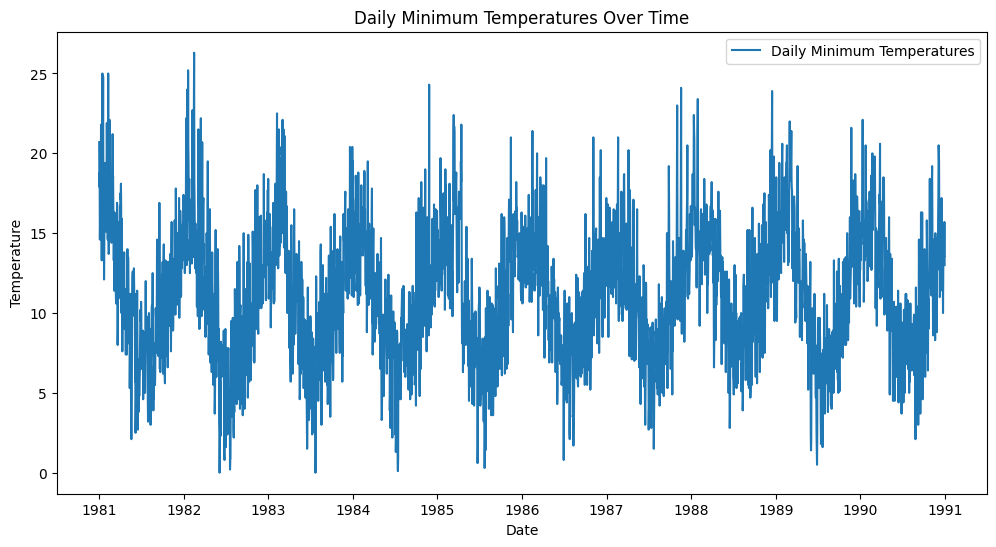

In [10]:
# 3) Разведочный анализ данных
df['Daily minimum temperatures'] = df['Daily minimum temperatures'].str.replace('?', '', regex=False)
df['Daily minimum temperatures'] = pd.to_numeric(df['Daily minimum temperatures'], errors='coerce')
df.dropna(inplace=True)  
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily minimum temperatures'], label='Daily Minimum Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Daily Minimum Temperatures Over Time')
plt.legend()
plt.show()


In [11]:
print("Доля пропусков:", df['Daily minimum temperatures'].isna().mean())
print("Максимальное значение:", df['Daily minimum temperatures'].max())
print("Минимальное значение:", df['Daily minimum temperatures'].min())
print("Среднее значение:", df['Daily minimum temperatures'].mean())
print("Медиана:", df['Daily minimum temperatures'].median())
print("Дисперсия:", df['Daily minimum temperatures'].var())
print("Квантиль 0.1:", df['Daily minimum temperatures'].quantile(0.1))
print("Квантиль 0.9:", df['Daily minimum temperatures'].quantile(0.9))
print("1-й квартиль:", df['Daily minimum temperatures'].quantile(0.25))
print("3-й квартиль:", df['Daily minimum temperatures'].quantile(0.75))


Доля пропусков: 0.0
Максимальное значение: 26.3
Минимальное значение: 0.0
Среднее значение: 11.177753424657535
Медиана: 11.0
Дисперсия: 16.579855735292462
Квантиль 0.1: 6.090000000000003
Квантиль 0.9: 16.3
1-й квартиль: 8.3
3-й квартиль: 14.0


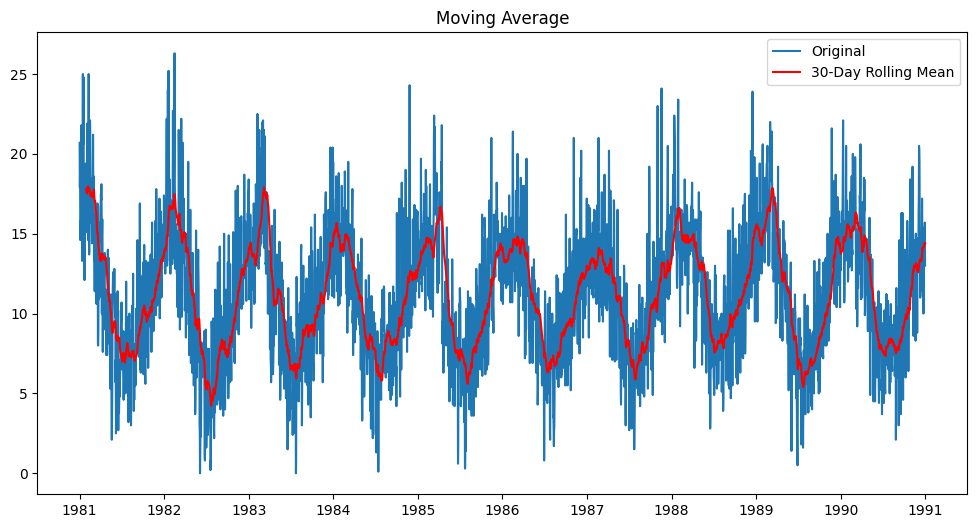

In [12]:
# 4) Анализ временного ряда
# Скользящее среднее
df['Rolling_Mean'] = df['Daily minimum temperatures'].rolling(window=30).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['Daily minimum temperatures'], label='Original')
plt.plot(df['Rolling_Mean'], label='30-Day Rolling Mean', color='red')
plt.legend()
plt.title('Moving Average')
plt.show()


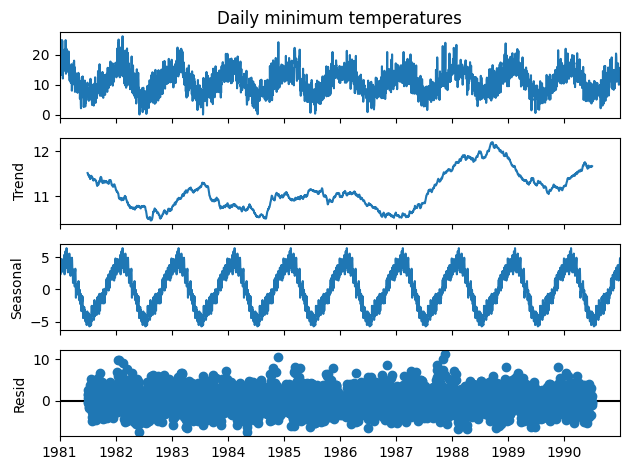

In [13]:
# Сезонная декомпозиция
decomposition = seasonal_decompose(df['Daily minimum temperatures'], model='additive', period=365)
decomposition.plot()
plt.show()

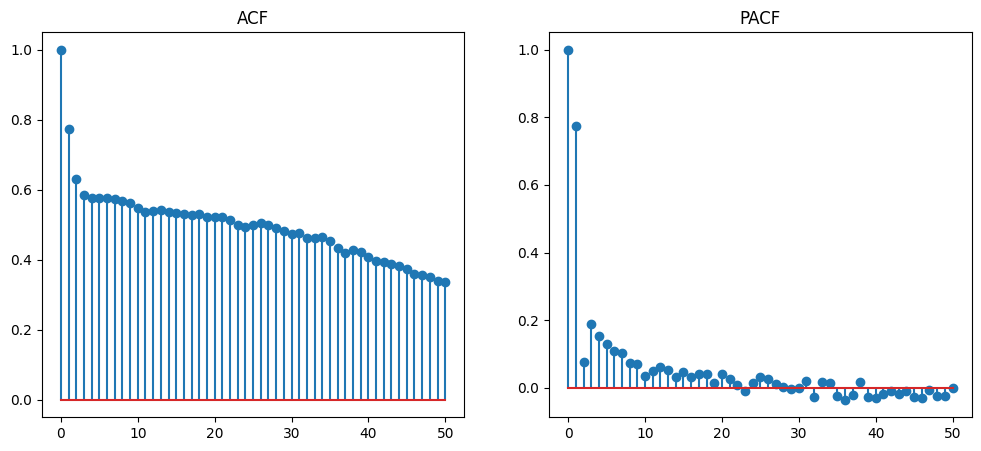

In [14]:
# Автокорреляция и частичная автокорреляция
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].stem(acf(df['Daily minimum temperatures'], nlags=50))
ax[0].set_title('ACF')
ax[1].stem(pacf(df['Daily minimum temperatures'], nlags=50))
ax[1].set_title('PACF')
plt.show()

In [15]:
# 5) Тест на стационарность
adf_test = adfuller(df['Daily minimum temperatures'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')
if adf_test[1] < 0.05:
    print("Ряд стационарен")
else:
    print("Ряд нестационарен")

ADF Statistic: -4.444804924611687
p-value: 0.00024708263003611164
Critical Values:
   1%: -3.4321532327220154
   5%: -2.862336767636517
   10%: -2.56719413172842
Ряд стационарен


In [16]:
# 6) Разделение на тренировочную и тестовую выборку
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [17]:
# 7) Автоматический подбор параметров ARIMA
arima_model = auto_arima(train['Daily minimum temperatures'], seasonal=False, stepwise=True, trace=True)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13550.819, Time=1.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22714.455, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14246.469, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19612.896, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13578.294, Time=0.51 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13588.505, Time=0.86 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=13590.061, Time=1.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=13551.524, Time=1.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14004.808, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=13549.744, Time=0.23 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=16924.072, Time=0.34 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=13551.637, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=17889.375, Time=0.29 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=16351.587, Time=0.54 sec
 ARIMA(2,0,4)(0,0,0

In [21]:
# 8) Обучение модели ARIMA
p, d, q = arima_model.order
model_arima = ARIMA(train['Daily minimum temperatures'], order=(p, d, q))
model_arima_fit = model_arima.fit()

# Прогноз ARIMA
test_array = test['Daily minimum temperatures'].to_numpy().flatten()  # Преобразуем в 1D-массив
arima_forecast = np.array(arima_forecast).flatten()  # То же самое для предсказаний

# Оценка ARIMA
print("ARIMA MAE:", mean_absolute_error(test_array, arima_forecast))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test_array, arima_forecast)))


D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA MAE: 3.310684232844288
ARIMA RMSE: 4.021785504807361


In [23]:
# 9) Автоматический подбор параметров SARIMA
sarima_model = auto_arima(train['Daily minimum temperatures'], seasonal=True, m=7, stepwise=True, trace=True)
print(sarima_model.summary())

# Обучение модели SARIMA
p, d, q = sarima_model.order
P, D, Q, s = sarima_model.seasonal_order
model_sarima = ARIMA(train['Daily minimum temperatures'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_sarima_fit = model_sarima.fit()

# Прогноз SARIMA
sarima_forecast = model_sarima_fit.forecast(steps=len(test))

# Оценка SARIMA
print("SARIMA MAE:", mean_absolute_error(test, sarima_forecast))
print("SARIMA RMSE:", np.sqrt(mean_squared_error(test, sarima_forecast)))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=5.71 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=16473.391, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=13898.728, Time=1.09 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14587.620, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=22714.455, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=13921.008, Time=0.26 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=13878.569, Time=2.84 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=13804.992, Time=5.52 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=13806.353, Time=2.54 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=8.56 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=13804.490, Time=5.77 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=13889.820, Time=1.69 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=13902.489, Time=0.66 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=14909.429, Time=4.77 sec
 ARIMA(2,0,0)(1,0,2)[7] interce

D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Yolo8\CVAT2YOLO\WORK\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Yolo8

ValueError: y_true and y_pred have different number of output (2!=1)

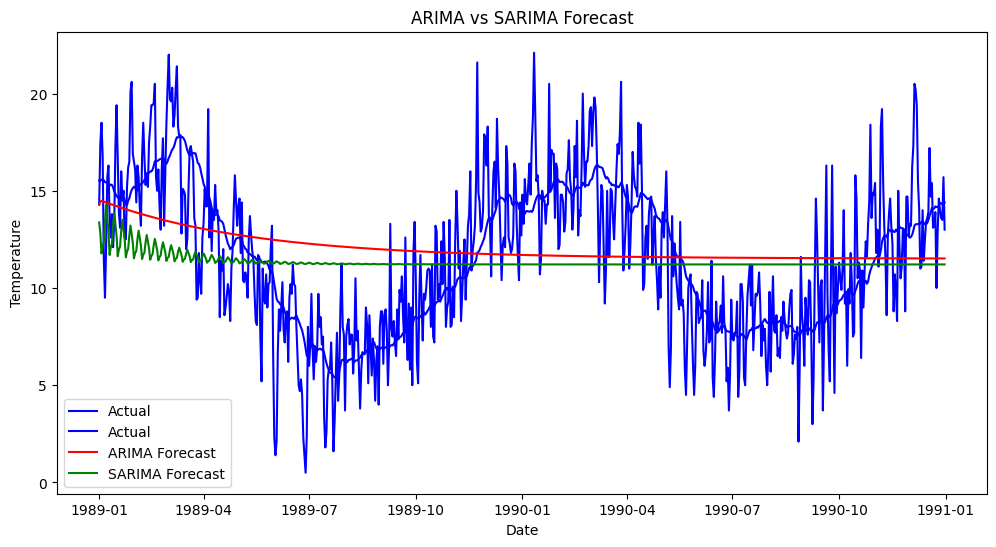

In [24]:
# 10) Графики прогнозов
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('ARIMA vs SARIMA Forecast')
plt.legend()
plt.show()